In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

In [3]:
'''
Step 0: Preprocessing and Properly Index the data
-> use parse dates to parse the dates to the correct position
-> set the index column to the dates to make plotting, indexing, and visualization easier
'''
df = pd.read_csv("Gemini_1INCHUSD_1h.csv", index_col = ['date'], parse_dates = True)
df = df[['open', 'high', 'low', 'close', 'Volume 1INCH', 'Volume USD']]
df.head(n=10) #customizable but may be deprecated soon

,open,high,low,close,Volume 1INCH,Volume USD
date,,,,,,
2022-04-27 00:00:00,1.2871,1.2932,1.2865,1.2888,428.840257,552.689323
2022-04-26 23:00:00,1.2968,1.2970,1.2589,1.2871,1189.529669,1531.043637
2022-04-26 22:00:00,1.3093,1.3124,1.2961,1.2968,1281.291941,1661.579389
2022-04-26 21:00:00,1.2981,1.3116,1.2959,1.3093,2868.856831,3756.194249
2022-04-26 20:00:00,1.3053,1.3095,1.2900,1.2981,2084.128819,2705.407620
2022-04-26 19:00:00,1.3203,1.3240,1.2917,1.3053,12134.329536,15838.940343
2022-04-26 18:00:00,1.3213,1.3213,1.3105,1.3203,460.162917,607.553099
2022-04-26 17:00:00,1.3324,1.3324,1.3104,1.3213,2447.070851,3233.314715
2022-04-26 16:00:00,1.3181,1.3362,1.3092,1.3324,1160.667932,1546.473953


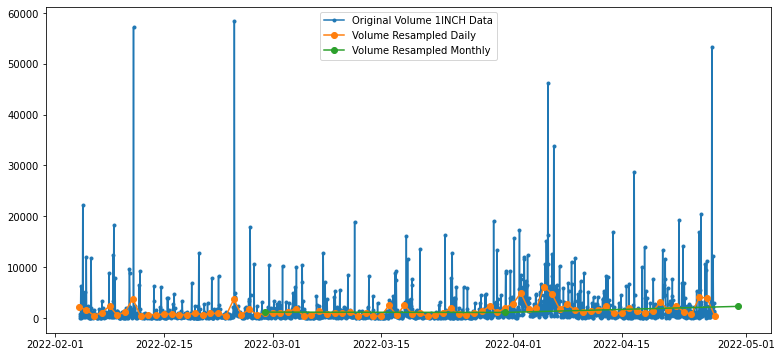

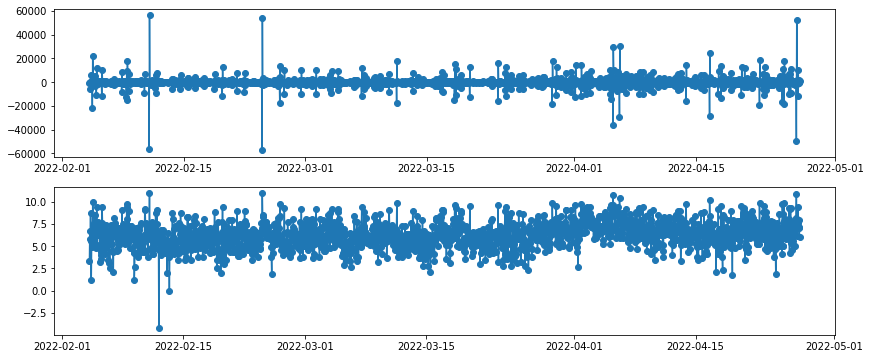

In [19]:
'''
Step 1 + 2: Visualize the Data -> Evaluate for Stationary (which will also be completed with ADFuller Test)
-> Conduct Resampling tests for Daily, Monthly, and Annual Seasonalities
-> Determine the stability of the Dataset presented in the data viz
-> Determine necessity of finding the first difference
-> Determine the neceessity of finding the log difference 
'''

y = df['Volume 1INCH']
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(y, marker = '.', linestyle = '-', label = "Original Volume 1INCH Data")
ax.plot(y.resample('D').mean(), marker = 'o', linestyle = '-', label = "Volume Resampled Daily")
ax.plot(y.resample('M').mean(), marker = 'o', linestyle = '-', label = "Volume Resampled Monthly")
#ax.plot(y.resample('Y').mean(), marker = 'o', linestyle = '-', label = "Volume Resampled Annual")
ax.legend()

df['First Difference'] = y - y.shift()
df['Log Volume'] = y.apply(lambda x: np.log(x))
fig, ax = plt.subplots(2, 1, figsize = (14, 6))
ax[0].plot(df['First Difference'], marker = 'o', linestyle = '-', label = "First Difference on Original Data")
ax[1].plot(df['Log Volume'], marker = 'o', linestyle = '-', label = "Log Volume Applied on Origianl data")

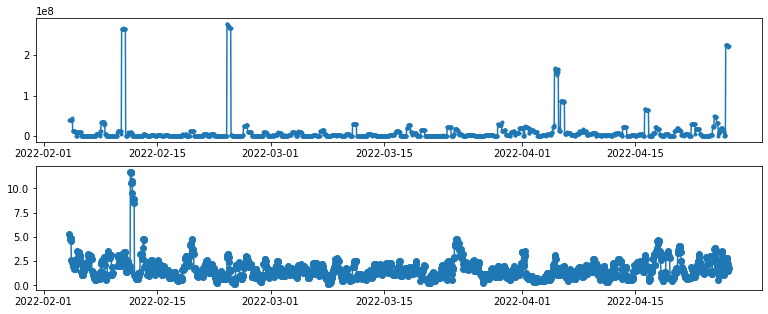

In [20]:
'''
Step 3: Find Rolling Variance, Rolling Mean, and Rolling STD
-> Used to measure and estimate the model necessity and stability of the data
'''
df['Original Volume Variance'] = pd.Series(y).rolling(window = 12).var()
df['Logged Volume Variance'] = pd.Series(df['Log Volume']).rolling(window = 12).var()
df['Original Volume - Rolling Mean'] = pd.Series(y).rolling(window = 12).var()
df['Logged Volume - Rolling Mean'] = pd.Series(df['Log Volume']).rolling(window = 12).var()

fig, ax = plt.subplots(2, 1, figsize = (13, 5))
ax[0].plot(df['Original Volume Variance'], marker = '.', label = "Original Volume Variance")
ax[1].plot(df['Logged Volume Variance'], marker = 'o', linestyle = '-', label = "Log Volume Variance")

C:\Users\kzhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\kzhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


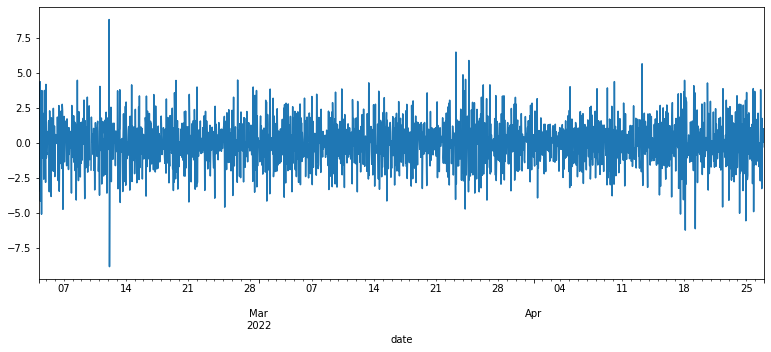

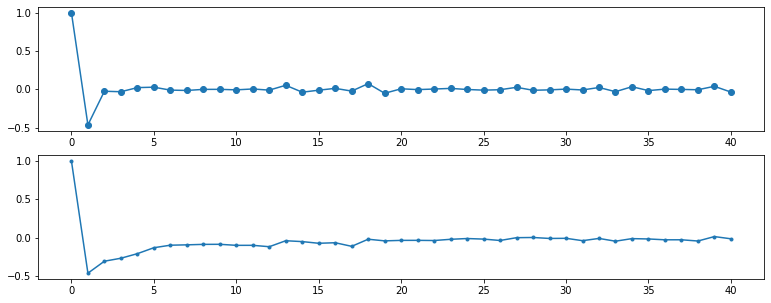

In [45]:
'''
Step 4: Judge the value of P and Q
According to historical articles, it can be determined by autocorrelation coefficient (ACF) and partial autocorrelation coefficient (PACF). 
AR (P) has p-order truncation and MA (q) has q-order truncation;
'''
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df['Log Vol 1st Diff'] = df['Log Volume'] - df['Log Volume'].shift(1)
df['Log Vol 1st Diff'].plot(figsize = (13, 5))

lag_corr = acf(df['First Difference'].iloc[1:], fft = False)
partial_lag_corr = pacf(df['First Difference'].iloc[1:])
fig, ax = plt.subplots(2, 1, figsize = (13, 5))
ax[0].plot(lag_corr, marker = 'o', linestyle = '-')
ax[1].plot(partial_lag_corr, marker = '.', linestyle = '-')

<ipython-input-47-563e863282b1>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = sm.tsa.seasonal_decompose(df['Volume 1INCH'], model = 'additive', freq = 30)


<Figure size 1728x432 with 0 Axes>

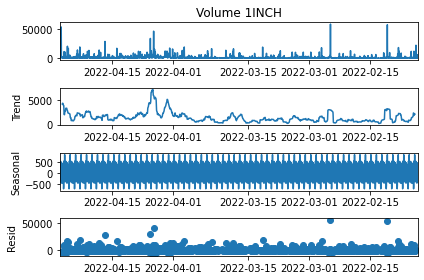

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = sm.tsa.seasonal_decompose(df['Volume 1INCH'], model = 'additive', freq = 30)
fig = plt.figure(figsize = (24, 6))
fig = decomposition.plot()